# COMP1801 Tutorial Week 8 - Neural Networks
*Dr Peter Soar - 2022/23*
$\newcommand{\Vec}[1]{\boldsymbol{#1}}$
$\newcommand{\Mat}[1]{\boldsymbol{#1}}$

This tutorial should be pulling together everything we have been learning so far in supervised learning. Neural Networks can be applied to both Regression and Classification problems to create complex deep learning models which if constructed and trained correctly should generally outperform any traditional linear models we've been dealing with so far. This tutorial should show you how to implement a general neural network using `tensorflow.keras` by combining differnt types of layers.

For this tutorial, read through and try to understand the text and code examples I have provided (ask your tutor if you have any questions) and there will be a selection of exercises. Attempt these exercises on your own, but do ask your tutor for help if you get stuck.

### Note: USE **GOOGLE COLAB** (not offline environments) to use Tensorflow. 

*   Tensorflow enables you to leverage GPUs.
*   Installing Tensorflow to your laptop/PC may cause technical problems.
*   **Ensure runtime is changed to GPU** to accelerate  execution speed.




#0. Do not forget to import all the Python Libraries being used!

In [1]:
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import sklearn.datasets # We want to be able to access the sklearn datasets again
from sklearn.preprocessing import StandardScaler # We will be using the imbuilt scaling functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful

# Below are a wide selection of tensorflow libraries we will need to construct our Neural networks.
from tensorflow.keras.activations import sigmoid, linear, relu # Activation functions we will use
from tensorflow.keras.models import Model, Sequential # Different mays of constructing models, we will primarily be covering the 'functional api' which uses `Model`
from tensorflow.keras.optimizers import SGD # We will be using the SGD optimiser today, though there are other options you may want to explore (such as Adam)
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy  # We will be using TFs MSE loss function for regression and BinaryCross Entropy for classification.
from tensorflow.keras.layers import Input, Dense, Dropout # The layers we will be using to construct our network.
from tensorflow.keras.regularizers import L1, L2 # Regularisation being used in model layers
from tensorflow.keras.metrics import BinaryAccuracy # Accuracy Metric for classification
from tensorflow.keras.callbacks import EarlyStopping # Allows Early Stopping regularisation method.

#1. Basic pipeline of implementing a neural network model in `tensorflow. keras` (Regression case).
We can implement various neural networks using `tensorflow.keras`. First, we discuss multi-layer perceptron (fully connected neural network) as the easiest model before going into trying to construct more complicated models in the exercises.

## 1.1 Data preparation

Load the house price data:

To keep things strightforward and get straight to building the Neural Networks, we don't want to deal with data cleansing and EDA like you covered last week. For this reason, we will be take the now very familliar California House Price dataset (and later for classification the breast cancer dataset) as our examples. 

Differently from `sklearn`, `tensorflow.keras` considers multivariable targets by default. Hence, it is convenient to convert the $m$-dimensional target column vector (a `pandas.Series` instance) into a matrix with size $m \times 1$, or 2-dimensional array (a `pandas.DataFrame` instance). Here, $m$ is the number of data points. We can convert a `pandas.Series` instance into a `pandas.DataFrame` instance by the `to_frame` method of the `pandas.Series` instance.

Other than this change, everything in this Data Preparation section should hopefully be familliar by now.

In [2]:
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# Convert the target column vector `Y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
# Note, it is now technically a matrix, hence the upper case Y.
Y_pd = y_pd.to_frame()

# Display the whole dataset
XY_pd = pd.concat([X_pd, Y_pd], axis=1)
display(XY_pd)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Data splitting:

We first convert the data into `numpy.ndarray`, then apply the `sklearn.model_selection.train_test_split` function.

In [16]:
# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy() 

# Split the data into training/test data
# While we have 20640 pairs of a feature and target, we use 20% only for the test, not for training and validation.
# `shuffle=True` for non-time series case. You should set `shuffle=False` to avoid future data being contaminated in the training data.
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

Normalization:

Fit a `sklearn.preprocessing.StandardScaler` instance to the training data, then transpose the validation and test data by the instance.

For advanced preprocessing operations for images and text (which we won't be covering in this module, but may be of interest for your MSc projects or in Applied Machine Learning next term), you can also use classes defined in the `tensorflow.keras.preprocessing` module ([see here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing)).


In [17]:
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

Confirm the shape of the feature matrix:

While it is always a good idea to check the dimensions of your data, this is particularly important when defining a neural network in `tensorflow.keras` as we need to know the shape (dimension) of the input (feature).



$$
{\Vec{a}^{\mathrm{out}}}^\top = f (\Vec{b}^\top + {\Vec{a}^{\mathrm{in}}}^\top \Mat{W})
$$

In [5]:
print('The shape of `X_train`:', X_train.shape)
print('The shape of `X_valid`:', X_valid.shape)
print('The shape of `X_test`:', X_test.shape)

The shape of `X_train`: (12384, 8)
The shape of `X_valid`: (4128, 8)
The shape of `X_test`: (4128, 8)


The above results show that, for example, we have 12384 data points in the training data, and the features of each data point is 8-dimensional.

## 1.2 Create a neural network model by composing `tensorflow.keras` layers.
In the machine learning context, all of the models we have been considering are defined as a parametrized function, so our task here is how we can achieve that for a Neural Network model.

In `tensorflow.keras`, we define this parametrized function by composing neural network layers, each of which are themselves a Neural Network. Likewise, the graph structure of the neural network is defined by teh composition of these layers.

### 1.2.1 Define neural network layers
First, we create layer instances to be composed to define our neural network model. Specifically, we create instances of classes in the `tensorflow.keras.layers` module, specifying an activation function by taking a function in the `tensorflow.keras.activations` module as an `activation` argument in the initializer of the layer class. 

As an example, we create `tensorflow.keras.layers.Dense` instances (fully connected layers) in the cell below.

The function defined by the `Dense` layer is as follows:
$$
{\Vec{a}^{\mathrm{out}}}^\top = f (\Vec{b}^\top + {\Vec{a}^{\mathrm{in}}}^\top \Mat{W}),
$$
where

- ${\Vec{a}^{\mathrm{in}}}^\top$: the input row vector of the layer. We denote the dimensionality of the ${\Vec{a}^{\mathrm{in}}}^\top$ by $n^{\mathrm{in}}$.
- ${\Vec{a}^{\mathrm{out}}}^\top$: the output row vector of the layer. We denote the dimensionality of the ${\Vec{a}^{\mathrm{out}}}^\top$ by $n^{\mathrm{out}}$. We specify $n^{\mathrm{out}}$ by the `units` parameter in the `Dense` class's initializer.
- $\Mat{W}$: a matrix of size $n^{\mathrm{in}} \times n^{\mathrm{out}}$ called the "kernel" parameter of the layer. Each parameter of the matrix is a learnable parameter.
- $\Vec{b}^\top$: an $n^{\mathrm{out}}$-dimensional row vector called the "bias" parameter of the layer. Each parameter of the vector is a learnable parameter.
- $f$: a scalar function called the "activation function" of the layer. Although $f$ is defined as a scalar function, it is applied to an $n^{\mathrm{out}}$-dimensional vector elementwisely in the layer. Note that $f$ is fixed and not learnable, that is, invariant throughout the training process. The activation function $f$ is specified by the `activation` parameter in the `Dense` class's initializer.

The activation function of the first and second layers we are going to use in this case is the sigmoid function given by `tensorflow.keras.activation.sigmoid` function, and that of the third layer is the identity function given by the `tensorflow.keras.activation.linear` function.

The sigmoid function $\varsigma$ is defined by
$$
\varsigma (z) = \frac{1}{1 + \exp(- z)},
$$
and the identity function $\mathop{\mathrm{id}}$ is defined by
$$
\mathop{\mathrm{id}} (z) = z.
$$

For other layers, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and for other activation functions, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/activations).

Note: For regression problems we should always use the identity function, but the other activations become more important for classification.


In [18]:
# Define the first `Dense` layer.
# The output dimension is 5, so we specify `units=5`.
# The activation function is the sigmoid function, we specify `activation=sigmoid`.
first_layer = Dense(units=5, activation=sigmoid)

# Define the second `Dense` layer.
# The output dimension is 5, so we specify `units=5`.
# The activation function is the sigmoid function, we specify `activation=sigmoid`.
second_layer = Dense(units=5, activation=sigmoid)

# Define the third `Dense` layer.
# The output dimension is 1, so we specify `units=1`.
# The activation function is the identity function, we specify `activation=linear`.
third_layer = Dense(units=1, activation=linear)

### 1.2.2 Compose layers.

First, we create a `tensorflow.keras.layers.Input` instance as a **virtual input**, specifying the input shape as a `shape` argument in the initializer. 
Here, we omit the data size (the number of data points) from the argument. For example, our training data shape (`X_train.shape`) is `(12384, 8)` where the zeroth element indicates the data size and the first element is the number of features/columns, which will be our input. Hence we can manually specify `shape=(8, )` or extract the data using `shape=X_train.shape[1:]`.


In [7]:
# Extract the number of features for our Networks input dimension
features=X_train.shape[1:]
# Define the "virtual" input
input = Input(shape=features)

Note: For image processing problems, the input shape is often like `(data_size, width, height, channels)`, meaning we specify `shape=(width, height, channels)`.



Once we create a `Input` instance, we "call" the first layer instance taking the `Input` instance as an argument.
Subsequently, we call the second layer instance taking the output of the first layer as an argument. We continue this process for as many layers as we require.


In [19]:
# Call the layers in a row to get a "virtual" output
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)


Once we have composed our final virtual output, we can create a `tf.keras.models.Model` instance, taking the virtual input (the `Input` instance) and virtual output (the return value of the last layer). This `Model` instance is the NN model that we have implemented, that can now be trained on data and used to make predictions like we have done with the `linear` model instances in previous weeks.



In [20]:
# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='multi_layer_perception')

We can show the summary of our model by `summary` method of our `Model` instance. Which is always a good sainity check to ensure that our model seems to be functioning how we would expect.

In [21]:
model.summary()

Model: "multi_layer_perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


## 1.2.3 Example of the hypothesis function created by above model
The above neural network represent the composition of the functions represented by the three `Dense` layers. Below is how we would write this NN model in functional form.

Let ${\Vec{x}}^\top$ be the input row vector. The output $\eta$ of the neural network is given by
$$
{\Vec{a}^{[1]}}^\top = \varsigma ({\Vec{b}^{[1]}}^\top + {\Vec{x}}^\top \Mat{W}^{[1]}), \\
{\Vec{a}^{[2]}}^\top = \varsigma ({\Vec{b}^{[2]}}^\top + {\Vec{a}^{[1]}}^\top \Mat{W}^{[2]}), \\
\eta = b^{[3]} + {\Vec{a}^{[2]}}^\top \Vec{w}^{[3]}. \\
$$
where

- $\Mat{W}^{[1]}$: the "kernel" parameter of the first layer, a matrix of size $8 \times 5$.
- ${\Vec{b}^{[1]}}^\top$: the "bias" parameter of the first layer, an $5$-dimensional row vector.
- $\Mat{W}^{[2]}$: the "kernel" parameter of the second layer, a matrix of size $5 \times 5$.
- ${\Vec{b}^{[2]}}^\top$: the "bias" parameter of the second layer, an $5$-dimensional row vector.
- $\Vec{w}^{[3]}$: the "kernel" parameter of the third layer, a 5-dimensional row vector.
- $b^{[3]}$: the "bias" parameter of the third layer, a scalar.

We can also write the function in one line as follows:

$$
\eta = b^{[3]} + \varsigma ({\Vec{b}^{[2]}}^\top + \varsigma ({\Vec{b}^{[1]}}^\top + {\Vec{x}}^\top \Mat{W}^{[1]}) \Mat{W}^{[2]}) \Vec{w}^{[3]}
$$

Which really underlines just how the outputs of multi-layered neural networks are really just nested parameterised functions.

## 1.3 Training the model.

### 1.3.1 "Compile" the model: specifying a loss function and optimizer.
Now we have defined a machine learning model as a set of parametrized functions, to train the model (or find the optimal parameters) we need to specify a loss function and an optimizer (an optimization algorithm).

We can applly this by "compiling" the model. We execute this process by the `compile` method of the `Model` instance.

In `tensorflow.keras`, we use an instance of a class in the `tensorflow.keras.losses` module as a loss function, and one in the `tensorflow.keras.optimizers` module as an optimizer. Specifically, we take a loss instance and optimizer instance as a `loss` and `optimizer` arguments of the `compile` method.

In the cell below, we use a `tensorflow.keras.losses.MeanSquaredError` instance as a loss function, and a `tensorflow.keras.optimizers.SGD` (vanilla stochastic gradient descent) instance as an optimizer. For other loss functions, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and for other optimizers, see  [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). `tensorflow.keras.optimizers.Adam` is also often used.


In [23]:
# Compile the model by specifying the optimization algorithm and the loss function.
# Here, we specify the vanilla stochastic gradient descent 
# (a `tensorflow.keras.optimizers.SGD` instance) as an optimizer,
# and mean squared error (a `MeanSquaredError` instance) as a loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

### 1.3.2 "Fit" the model to the training data: Optimizing the parameters.
Similar to a machine learning model instance in `sklearn`, we can train a neural network machine learning model defined by `tensorflow` using the `fit` method. The `fit` method apply the **forwardpropagation and backpropagation** to calculate the gradient vector.  

Here, we specify the number of epochs (`epochs`) and the mini batch size (`batch_size`). The definitions of these terms are as follows:

In the optimization by a stochastic gradient descent method, each update does not consider all the training data points at the same time. 
Instead, each update considers a subset of the dataset, called a **mini batch**. 
We first shuffle the training data points and and divide them into multiple mini batches. 
Then, we update parameters based on the loss function and gradient vector for each mini batch. 
A pass through the mini batches that cover all the training data points once is called an **epoch**. 
Once we completed the updates based on all the mini batches in an epoch, we shuffle the training data points and divide them into new mini batches again, which begins a new epoch.

For example, if we have 12384 training data points and the mini batch size is 1000, each epoch contains 13 mini batches, where each of the first 12 mini batches contains 1000 training data points and the last mini batch contains 384 data points. Hence, each epoch conducts 13 updates. If the number of epochs is 10, the algorithm updates the parameters 13x10=130 times.

We can also input the validation data. If you input them, the loss function on the validation data will be displayed during the training. Note that the validation data does not affect the training results but can be used to identify overfitting.

Epoch 1/100
124/124 [==============================] - 1s 3ms/step - loss: 1.5560 - val_loss: 1.2890
Epoch 2/100
124/124 [==============================] - 0s 3ms/step - loss: 1.2495 - val_loss: 1.2459
Epoch 3/100
124/124 [==============================] - 0s 2ms/step - loss: 1.2047 - val_loss: 1.2000
Epoch 4/100
124/124 [==============================] - 0s 2ms/step - loss: 1.1539 - val_loss: 1.1468
Epoch 5/100
124/124 [==============================] - 0s 2ms/step - loss: 1.0964 - val_loss: 1.0872
Epoch 6/100
124/124 [==============================] - 0s 2ms/step - loss: 1.0324 - val_loss: 1.0222
Epoch 7/100
124/124 [==============================] - 0s 2ms/step - loss: 0.9647 - val_loss: 0.9555
Epoch 8/100
124/124 [==============================] - 0s 2ms/step - loss: 0.8980 - val_loss: 0.8918
Epoch 9/100
124/124 [==============================] - 0s 2ms/step - loss: 0.8370 - val_loss: 0.8352
Epoch 10/100
124/124 [==============================] - 0s 2ms/step - loss: 0.7846 - val_lo

124/124 [==============================] - 0s 3ms/step - loss: 0.3908 - val_loss: 0.4093
Epoch 82/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3907 - val_loss: 0.4088
Epoch 83/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3902 - val_loss: 0.4088
Epoch 84/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3899 - val_loss: 0.4089
Epoch 85/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3898 - val_loss: 0.4084
Epoch 86/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3894 - val_loss: 0.4080
Epoch 87/100
124/124 [==============================] - 0s 3ms/step - loss: 0.3893 - val_loss: 0.4080
Epoch 88/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3891 - val_loss: 0.4077
Epoch 89/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3888 - val_loss: 0.4080
Epoch 90/100
124/124 [==============================] - 0s 2ms/step - loss: 0.3885 - val_loss: 

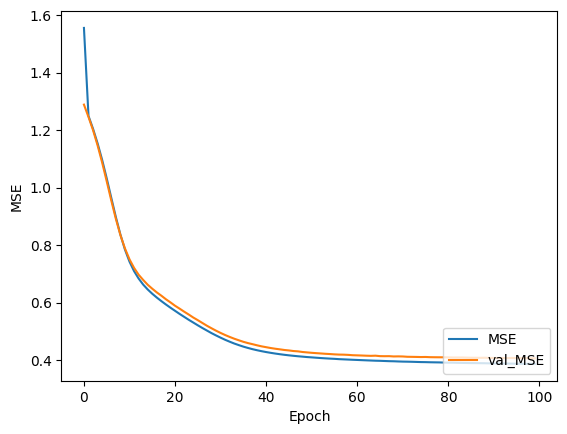

In [24]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.
# We don't actually need to save the fit model to a new variable to train our model, but saving the output
# this way lets us make a graph of the training and validation performance.
history = model.fit(X_train, Y_train, batch_size=100, epochs=100, validation_data=(X_valid, Y_valid))

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

You can see that each epoch contains 13 mini batches. `loss` and `val_loss` show the loss (the mean squared error) on the training data and the validation data, respectively. The losses almost monotonously decrease throughout the training. In this case our validation MSE is lower than our training, as both are still continuing to reduce there is no overfitting but we should consider trining this model for longer.

## 1.4 Evaluation of the NN model
We can evaluate the loss function on a new dataset by the `evaluate` method of the `Model` instance.


In [25]:
mse_on_test = model.evaluate(X_test, Y_test)
print('The mean squared error on the test data:', mse_on_test)

129/129 [==============================] - 0s 2ms/step - loss: 0.3894
The mean squared error on the test data: 0.3894026577472687


This MSE looks to be in the same region as we saw for our validation data, so no evidence of overfitting here.
We can make a prediction using the `predict` method just as we did in the `sklearn` cases. We can see how these predictions compare with our observed values and calculate the score function just as we did with out linear models.

129/129 [==============================] - 0s 2ms/step


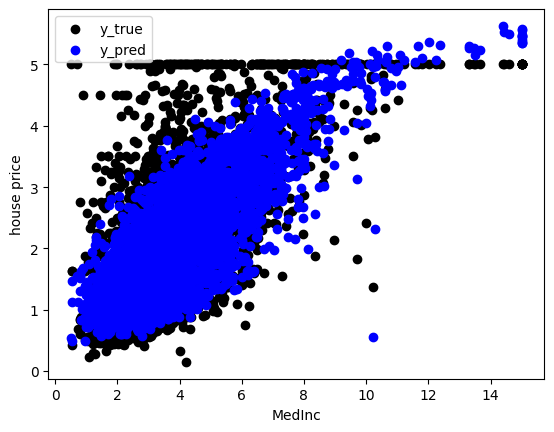

R2 score: 0.7014


In [26]:
Y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], Y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], Y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(Y_test, Y_test_pred)))

## 1.5 Exercise 1
So, our model above is performing okay, but honestly the Neural Network we've made here isn't that great and clearly needs more training if nothing else. Don't spend too long on this, but manually experiment with the model to see if you can make it more accurate (ideally without just training it for 1000's of steps!).

Some things to try changing:
*   More hidden layers
*   More units in the hidden layers (remember that we generally want teh same number of hidden units in each layer)
*   Different activation functions in the hidden layers (say `relu` which is probably more appropriate for this type of problem, but you can try others, again these should generally be the same for each layer other than the output.)
*   Different compiler option hyperparameters such as batch size, number of epochs, learning rate.





In [15]:
##############################################################
# Your code here
##############################################################
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()


X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=128*4, activation=relu)
second_layer = Dense(units=128*4, activation=relu)
third_layer = Dense(units=128*4, activation=relu)
forth_layer = Dense(units=128*4, activation=relu)
fifth_layer = Dense(units=128*4, activation=relu)
out_layer = Dense(units=1, activation=linear)

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)
output = forth_layer(output)
output = fifth_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Exercise_1')
model.summary()

Model: "Exercise_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 512)               4608      
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 1)                 5

Epoch 1/100
13/13 [==============================] - 2s 81ms/step - loss: 3.3111 - val_loss: 1.8020
Epoch 2/100
13/13 [==============================] - 1s 56ms/step - loss: 1.1893 - val_loss: 1.0769
Epoch 3/100
13/13 [==============================] - 1s 58ms/step - loss: 0.8440 - val_loss: 0.8045
Epoch 4/100
13/13 [==============================] - 1s 59ms/step - loss: 0.7003 - val_loss: 0.6863
Epoch 5/100
13/13 [==============================] - 1s 55ms/step - loss: 0.6383 - val_loss: 0.6385
Epoch 6/100
13/13 [==============================] - 1s 57ms/step - loss: 0.6054 - val_loss: 0.6094
Epoch 7/100
13/13 [==============================] - 1s 60ms/step - loss: 0.5813 - val_loss: 0.5880
Epoch 8/100
13/13 [==============================] - 1s 61ms/step - loss: 0.5601 - val_loss: 0.5721
Epoch 9/100
13/13 [==============================] - 1s 59ms/step - loss: 0.5408 - val_loss: 0.5511
Epoch 10/100
13/13 [==============================] - 1s 59ms/step - loss: 0.5236 - val_loss: 0.5354

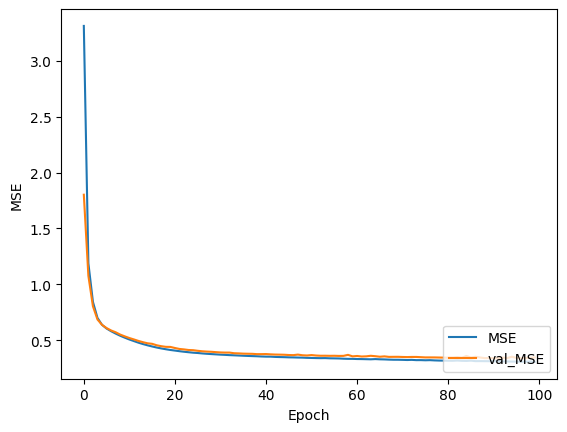

In [16]:
# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

# Train the model.
history = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

129/129 [==============================] - 1s 6ms/step - loss: 0.3300
The mean squared error on the test data: 0.33001798391342163
129/129 [==============================] - 1s 6ms/step


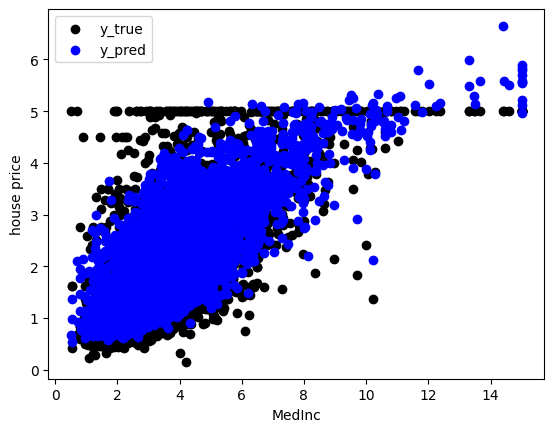

R2 score: 0.7469


In [17]:
mse_on_test = model.evaluate(X_test, Y_test)
print('The mean squared error on the test data:', mse_on_test)

Y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], Y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], Y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(Y_test, Y_test_pred)))

## 1.6 Exercise 2
As a test to see if you understand what we are actually doing with these Neural Network Layers, are you able to create a multivariate linear regression model using a Neural Network layer. If the activation function $f$ is the identity function (the function that returns the arguments without any modification) and the output vector dimension is one, the function defined by a `Dense` layer is equivalent to the hypothesis function of the linear regression model.

Go back and check the basic multivariable linear regression example (so without polynomial features or regularisation) for the California Housing Dataset in **Week 5** and see if we are getting the same answer (Make sure your model is fully trained and that any sampling/shuffling is the same!)

Hints:
*   We only need one `Dense` layer.
*   Recall that the linear regression model is defined by 
$$
h_{\Vec{\theta}} ({\Vec{x}^{(i)}}) = \theta_{0} + {\Vec{x}^{(i)}} \Vec{\theta}.
$$



Model: "Exercise_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 0s 16ms/step - loss: 6.1891 - val_loss: 5.3326
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 3.7599 - val_loss: 3.3143
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 2.4391 - val_loss: 2.2190
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 1.7022 - val_loss: 1.5947
Epoch 5/100
13/13 [==============================] - 0s 4ms/s

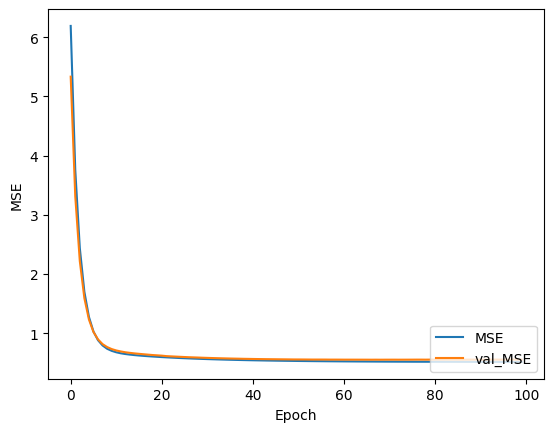

129/129 [==============================] - 0s 3ms/step - loss: 0.5350
The mean squared error on the test data: 0.5349653959274292
129/129 [==============================] - 0s 2ms/step


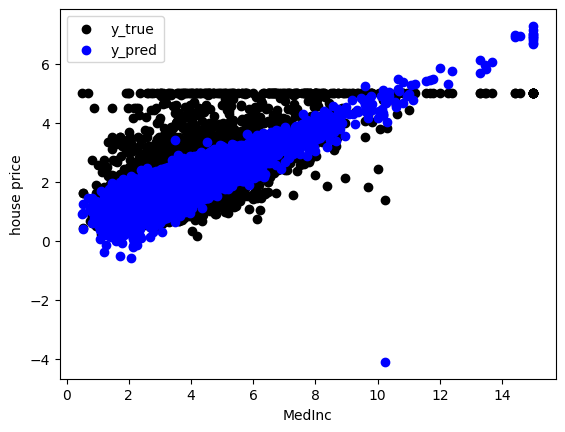

R2 score: 0.5897


In [18]:
##############################################################
# Your code here
##############################################################
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()


X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

input = Input(shape=X_train.shape[1:])
dense_layer = Dense(units=1, activation=linear)

# Define the "virtual" output
output = dense_layer(input)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Exercise_2')
model.summary()

# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

# Train the model.
history = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

mse_on_test = model.evaluate(X_test, Y_test)
print('The mean squared error on the test data:', mse_on_test)

Y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], Y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], Y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(Y_test, Y_test_pred)))

# 2. Classification with Neural Networks

Above we were using a Neural network to solve a regression problem. The process is very similar for classification problems, but there are some important distinctions we need to consider.

In the following, we discuss classification. Here, we also learn

- How to apply regularization.
- How to specify a metric function different from the loss function.
- How to care imbalance classes.

## 2.1 Data preparation


As with the regression case, all of this should be quite familliar, and in this case we will be using the breast cancer data for our classification task.

In [19]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Convert the target column vector `Y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
Y_pd = y_pd.to_frame()

# Display the dataset
XY_pd = pd.concat([X_pd, Y_pd], axis=1)
display(XY_pd)

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()

# Split the data into training/test data
# While we have 569 pairs of a feature and target, we use 20% only for the test, not for training and validation.
# `shuffle=True` for non-time series case. You should set `shuffle=False` to avoid future data being contaminated in the training data.
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


Confirm the shape of the feature matrix:

While it is always a good idea to check the dimensions of your data, this is particularly important when defining a neural network in `tensorflow.keras` as we need to know the shape (dimension) of the input (feature).

In [20]:
print('The shape of `X_train`:', X_train.shape)
print('The shape of `X_valid`:', X_valid.shape)
print('The shape of `X_test`:', X_test.shape)

The shape of `X_train`: (341, 30)
The shape of `X_valid`: (114, 30)
The shape of `X_test`: (114, 30)


The above results show that, for example, we have 341 data points in the training data, and the features for each data point is 30-dimensional.

## 2.2 Create a neural network model.
For classification, we define a discriminant function, which output a real value. This is because the loss function is defined on the output of the discriminant function, not of the hypothesis function, which outputs the target value.

The activation function is very important for our output layer in classification. You can just use a `linear` identify function, but you will have to manually do something to this output to make it work for classification. Generally for binary classification `sigmoid` is uses (as it gives a value between 0 and 1) and for multi class classification `softmax` is used (as it gives a probability for each class, but don't worry too much about this as we're not looking at multi-class problems right now).

As we discussed in previous lectures, we need regularisation to make the optimization stable in logistic regression (not just to avoid overfitting, though it is still helpful for this).

Here, we apply the l2 regularization on the kernel parameters $\Vec{\theta}$. Specifically, we create a `tensorflow.keras.regularizers.L2` instance, specifying the regularization weight as a `l2` argument, and input the `L2` instance as a `kernel_regularizer` argument in the initializer of the `Dense` class.

For other regularizers, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers).

**Note:** We can also use regularizers in NN's for regression, which while less critical can still benefit from the optimisation stability and protection from overfitting.


In [21]:
# Define the regularizer.
alpha = 0.01
kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layer.
# The output dimension is 1, so we specify `units=1`.
# The as we are performing binary classification, we specify `activation=sigmoid`.
# We apply l2 regularization on the kernel parameters by specifying a `kernel_regularizer` argument.
dense_layer_1 = Dense(units=10, activation=relu, kernel_regularizer=kernel_regularizer)
output_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = output_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='logistic_regression')

# Output the summary of the model.
model.summary()



Model: "logistic_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


##2.3 Train the model

### 2.3.1 "Compile" the model: specifying a loss function, metrics and an optimizer.
Since logistic regression's loss function is the cross entropy, we create a `tensorflow.keras.losses.BinaryCrossentropy` instance and specify it as a `loss` argument of the `compile` method of the `Model` instance.
The binary cross entropy loss is defined as follows:
$$
\log (1 + \exp(- y \cdot \eta)),
$$
where $y$ is the true target value converted to either -1 or +1 and $\eta$ is the output of the discriminant function. The above definition is used if `from_logits=True` in the initializer of the `BinaryCrossentropy` class which we need because we are not specifying a `sigmoid` function output.

Also, since we may also wish to observe evaluation metrics different from the loss function in classification, such as the accuracy score, we can specify metrics in the `compile` method. Specifically, we can input a list or tuple of instances of classes in the `tensorflow.keras.metrics` module. In the following cell, we create a `tensorflow.keras.metrics.BinaryAccuracy` instance, specifying `threshold=0.0`, and specify a list containing the `BinaryAccuracy` instance as a `metrics` argument of the `compile` method of the `Model` instance.

For other metrics, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).

In [22]:
# Compile the model by specifying the optimization algorithm and the loss function.
# Here, we specify the vanilla stochastic gradient descent 
# (a `tensorflow.keras.optimizers.SGD` instance) as an optimizer,
# and the binary cross entropy function (a `BinaryCrossentropy` instance) 
# as a loss function.

# If we want to observe metrics other than the loss function we specified,
# we can also specify the metrics in the `metrics` parameter 
# in the `compile` method. 

sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])


### 2.3.2 "Fit" the model to the training data: Optimizing the parameters.
In `tensorflow.keras`, we specify a class weight when we fit the model. Here, we have to specify the weight manually. Specifically, we create a Python dictionary such that keys are the class labels and values indicate the class weight. Revise Lecture 06 for the class weight.

Epoch 1/50
4/4 [==============================] - 1s 111ms/step - loss: 1.1863 - binary_accuracy: 0.2258 - val_loss: 1.1448 - val_binary_accuracy: 0.3158
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 1.1033 - binary_accuracy: 0.2903 - val_loss: 1.0685 - val_binary_accuracy: 0.3421
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 1.0319 - binary_accuracy: 0.3431 - val_loss: 1.0001 - val_binary_accuracy: 0.4123
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.9689 - binary_accuracy: 0.4135 - val_loss: 0.9421 - val_binary_accuracy: 0.4912
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.9154 - binary_accuracy: 0.4897 - val_loss: 0.8909 - val_binary_accuracy: 0.5702
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 0.8680 - binary_accuracy: 0.5572 - val_loss: 0.8446 - val_binary_accuracy: 0.6053
Epoch 7/50
4/4 [==============================] - 0s 19ms/step - loss: 0.8255 - b

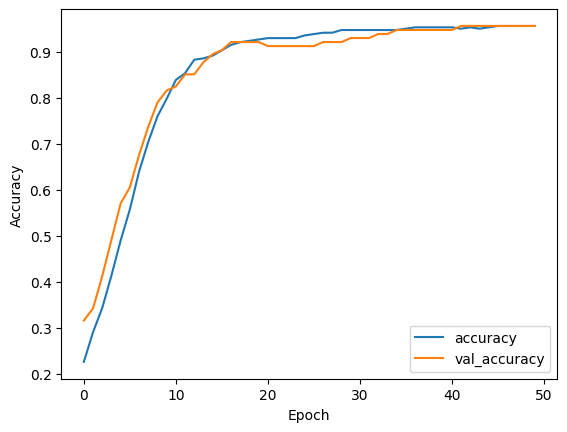

In [23]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.

history = model.fit(X_train, Y_train, batch_size=100, epochs=50, validation_data=(X_valid, Y_valid))


# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

You can see that each epoch contains 4 mini batches. `loss` and `val_loss` show the loss function being used (the Binary Cross Entropy) on the training data and the validation data, but now we can also see our chosen accuracy metric for our model.

## 2.4 Evaluation of the NN model
we can calculate the loss and score at the same time using the `evaluate` method of the `Model` instance.

In [24]:
ce_test, acc_test = model.evaluate(X_test, Y_test)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

4/4 [==============================] - 0s 1ms/step - loss: 0.4037 - binary_accuracy: 0.9561
The cross entropy loss on the test data: 0.40372276306152344
The accuracy on the test data: 0.9561403393745422


This seems to be less accurate than our previous model outputs may lead us to expect, so possibly some overfitting is occuring, but we will come to that shortly.

We can make a prediction using the `predict` method just as we did in the `sklearn` cases.

Although our objective is classification, the `tensorflow.keras` model itself does not distinguish classification and regression. Hence, the outputs using the `predict` method is that of the discriminant function. For this reason, we will get a sequence of real values. 

In [25]:
Y_test_logit = model.predict(X_test)
print(Y_test_logit[:10]) # just show you the first 10 to not spam you

4/4 [==============================] - 0s 2ms/step
[[0.29658905]
 [0.8659796 ]
 [0.91765964]
 [0.81230026]
 [0.9406031 ]
 [0.8354974 ]
 [0.95123833]
 [0.8480035 ]
 [0.90183383]
 [0.9475841 ]]


We can convert the above results to binary prediction by thresholding at 0.5.

In [26]:
Y_test_pred = (Y_test_logit > 0.5).astype(int)
print(Y_test_pred[:10])

[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


Finally, let's plot our outputs and look at our confusion matrix to further explore how well our model performed.

The accuracy on the test data with the selected hyperparameter: 0.956140350877193
The F1 score on the test data with the selected hyperparameter: 0.962962962962963
Precision on validation data: 0.9558823529411765
Recall on validation data: 0.9558823529411765


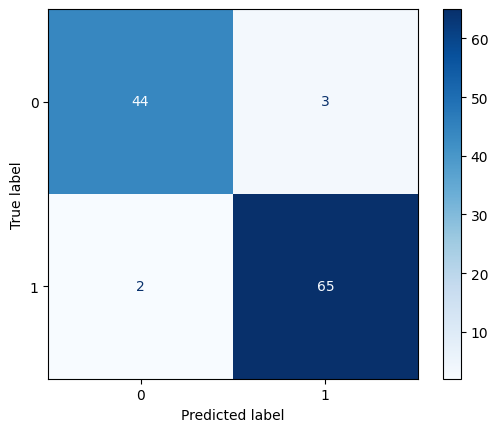

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)

acc_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Precision on validation data:', pre_test)
reca_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Recall on validation data:', reca_test)

## 2.5 Class imbalances

As covered in previous weeks, when perfomorming classification, the number of instances in each class can have an impact on how well the model predicts each class.

For the breast cancer dataset, the class imbalance isn't too bad, however we do have a slight imbalance that may be impacting our model. The first part of creating our model is the same:


In [28]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Convert the target column vector `Y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
Y_pd = y_pd.to_frame()

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()

# Split the data into training/test data
# While we have 569 pairs of a feature and target, we use 20% only for the test, not for training and validation.
# `shuffle=True` for non-time series case. You should set `shuffle=False` to avoid future data being contaminated in the training data.
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

# Define the regularizer.
alpha = 0.01
kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layers.
dense_layer_1 = Dense(units=10, activation=relu, kernel_regularizer=kernel_regularizer)
output_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = output_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='logistic_regression_balanced')

# Output the summary of the model.
model.summary()


sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])

Model: "logistic_regression_balanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_12 (Dense)            (None, 10)                310       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


What we change is at the 'fitting' stage - in `tensorflow.keras`, we can specify a class weight when we fit the model. 

Here, we have to specify the weight manually. Specifically, we create a Python dictionary such that keys are the class labels and values indicate the class weight.

Epoch 1/50
4/4 [==============================] - 1s 81ms/step - loss: 1.4352 - binary_accuracy: 0.3255 - val_loss: 1.2565 - val_binary_accuracy: 0.2456
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 1.2652 - binary_accuracy: 0.3900 - val_loss: 1.1206 - val_binary_accuracy: 0.3158
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 1.1230 - binary_accuracy: 0.4370 - val_loss: 1.0118 - val_binary_accuracy: 0.4386
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 1.0101 - binary_accuracy: 0.4839 - val_loss: 0.9149 - val_binary_accuracy: 0.5526
Epoch 5/50
4/4 [==============================] - 0s 12ms/step - loss: 0.9136 - binary_accuracy: 0.5748 - val_loss: 0.8408 - val_binary_accuracy: 0.6754
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 0.8391 - binary_accuracy: 0.6540 - val_loss: 0.7796 - val_binary_accuracy: 0.7456
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 0.7783 - bi

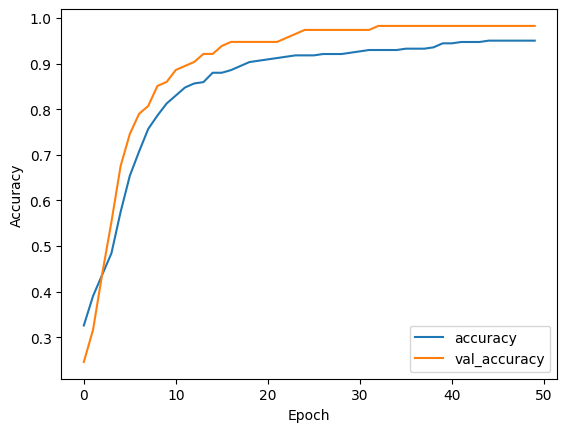

In [29]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.

m = {}
m[0] = np.sum((Y_train == 0).astype(int)) # Count how many times `0` appears in the target matrix.
m[1] = np.sum((Y_train == 1).astype(int)) # Count how many times `1` appears in the target matrix.
m_total = m[0] + m[1]
class_weight = {0: m_total / (2.0 * m[0]), 1: m_total / (2.0 * m[1])}

history = model.fit(X_train, Y_train, batch_size=100, epochs=50, validation_data=(X_valid, Y_valid), class_weight=class_weight)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

As the `class_weight` is not supported in the `evaluate` method for tensorflow if you want to measure this metric we can use `sklearn` functions.

In [30]:
Y_test_logit = model.predict(X_test)
Y_test_pred = (Y_test_logit > 0.5).astype(int)
bacc = balanced_accuracy_score(Y_test, Y_test_pred)
print('The balanced accuracy score on the test data:', bacc)

4/4 [==============================] - 0s 2ms/step
The balanced accuracy score on the test data: 0.893458240711337


But let's also use the same evaluation metrics we used for the unbalanced model - it's not much, but we do seem to be more accurate in our predictions!

The accuracy on the test data with the selected hyperparameter: 0.8859649122807017
The F1 score on the test data with the selected hyperparameter: 0.8976377952755905
Precision on test data: 0.95
Recall on test data: 0.95


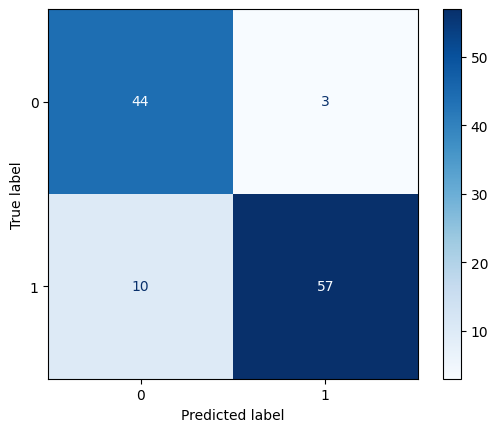

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)

acc_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Precision on test data:', pre_test)
reca_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Recall on test data:', reca_test)

##2.6 Exercise 3

So far we have just been using a neural network with one layer and not many units (less than our number of features in fact!). Add more layers and units to our NN and see if we can obtain even greater accuracy. I was able to get an f1 score of 0.97, can you beat me? (Though do remember, there is a stochastic element to the training of Neural Networks, so you may not always get the same accuracy running the same model moultiple times from the start. Still, if your model is well contructed they should be comparable)

Model: "Exercise_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_14 (Dense)            (None, 50)                1550      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 4,151
Trainable params: 4,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 1s 78ms/step - loss: 1.5522 - binary_accuracy: 0.4985 - val_loss: 1.5186 - val_binary_accuracy: 0.6053
Epoch 2/100
4/4 [===============

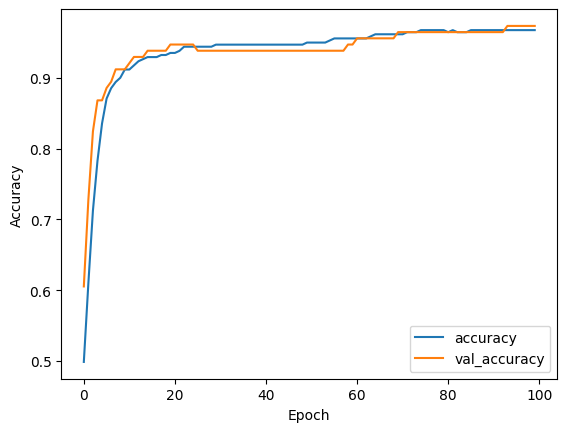

4/4 [==============================] - 0s 0s/step


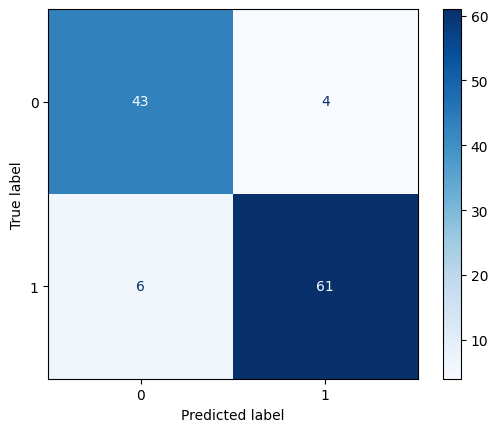

The accuracy on the test data with the selected hyperparameter: 0.9122807017543859
The F1 score on the test data with the selected hyperparameter: 0.9242424242424243
Precision on test data: 0.9384615384615385
Recall on test data: 0.9384615384615385


In [32]:
##############################################################
# Your code here
##############################################################
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Convert the target column vector `Y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
Y_pd = y_pd.to_frame()

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

# Define the regularizer.
alpha = 0.01
kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layer.
dense_layer_1 = Dense(units=50, activation=relu, kernel_regularizer=kernel_regularizer)
dense_layer_2 = Dense(units=50, activation=relu, kernel_regularizer=kernel_regularizer)
out_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = dense_layer_2(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Exercise_3')

# Output the summary of the model.
model.summary()

sgd = SGD(learning_rate=0.01)
ce = BinaryCrossentropy(from_logits=False)
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])

# Train the model.
m = {}
m[0] = np.sum((Y_train == 0).astype(int)) # Count how many times `0` appears in the target matrix.
m[1] = np.sum((Y_train == 1).astype(int)) # Count how many times `1` appears in the target matrix.
m_total = m[0] + m[1]
class_weight = {0: m_total / (2.0 * m[0]), 1: m_total / (2.0 * m[1])}

history = model.fit(X_train, Y_train, batch_size=100, epochs=100, validation_data=(X_valid, Y_valid), class_weight=class_weight)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Y_test_logit = model.predict(X_test)
Y_test_pred = (Y_test_logit > 0.5).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

acc_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Precision on test data:', pre_test)
reca_test = precision_score(Y_test, Y_test_pred, pos_label=1)
print('Recall on test data:', reca_test)

# 3. Parametric testing with Neural Networks

When constructing a Neural Network there are a number of things you may want to experiment with, including, but not limited to:

1. Type of preprocessing used (Standardization vs Normalization, different encoding, etc)  
2. Changing the number of hidden units in the network
3. Changing the number of layers in the network 
4. Using different activation functions in the hidden layers 
5. Compiling the model with different optimizers 
6. Changing the learning rates 
7. Train the model for more epochs 
8. Changing the batch sizes 
9. Trying different accuracy metrics 
10. Accounting for class imbalances

When testing these, you need to make sure you go about it systematically and keep records of what improves or harms your model accuracy - don't just change things ad hoc and hope you eventually hit on the perfect model randomly!

For the hyperparameters in particular (learning rate, regularisation strength, batch size, number of layers, number of units, etc) it is beneficial to tune these to obtain the best network.

While we may want to experiment with some of these manually, in general the smart way to do things involves automating the process as much as possible. In past week's you have been shown how to do this for the regularisation strength, so let's do it again here for a Neural Network!



In [33]:
# First we can define some functions to create our model then compile and train it
# This should make our lives a bit easier and the code clearer when it comes to finding the paramaters
def create_model(reg_str=0.01,n_hidden=50):
    kernel_regularizer = L2(l2=reg_str)
    dense_layer_1 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    dense_layer_2 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    out_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)
    input=Input(shape=X_train.shape[1:]) 
    # Note, we can stack our layers in a single line like this to save space, but this approach does make it harder adding and removing layers.
    output = out_layer(dense_layer_2(dense_layer_1(input)))    
    model = Model(inputs=[input], outputs=[output], name='ParaTest')
    return model

def model_compile_and_training(X_train, Y_train, X_valid, Y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100):
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid, Y_valid), verbose=0) # Verbose=0 suppresses the output
    return model, history

Now we can run the automated loop:

4/4 [==============================] - 0s 3ms/step
The best C: 0.01


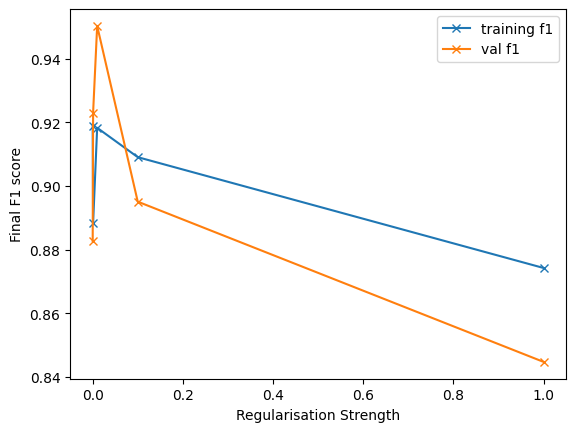

In [34]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Convert the target column vector `Y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
Y_pd = y_pd.to_frame()

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

Cs = [0.0001, 0.001, 0.01, 0.1, 1.0]
train_array = np.full([len(Cs)], np.nan)
valid_array = np.full([len(Cs)], np.nan)
f1_train_array = np.full([len(Cs)], np.nan)
f1_valid_array = np.full([len(Cs)], np.nan)

for C_index, C in enumerate(Cs):
  # Run our two functions to create and compile the model
  model = create_model(reg_str=C,n_hidden=50)
  model_compile_and_training(X_train, Y_train, X_valid, Y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100)

  Y_pred_train = model.predict(X_train)
  Y_pred_train = (Y_pred_train > 0.5).astype(int)

  train_array[C_index] = accuracy_score(Y_train, Y_pred_train)
  f1_train_array[C_index] = f1_score(Y_train, Y_pred_train, pos_label=1)

  Y_pred_valid = model.predict(X_valid)
  Y_pred_valid = (Y_pred_valid > 0.5).astype(int)

  valid_array[C_index] = accuracy_score(Y_valid, Y_pred_valid)
  f1_valid_array[C_index] = f1_score(Y_valid, Y_pred_valid, pos_label=1)


# Select our best performing C (biggest f1)
best_C_index = np.argmax(f1_valid_array)
best_C = Cs[best_C_index]
print('The best C:', best_C)

# plot the results
plt.figure()
plt.plot(Cs, f1_train_array, '-x', label='training f1')
plt.plot(Cs, f1_valid_array, '-x', label= 'val f1')
plt.xlabel('Regularisation Strength')
plt.ylabel('Final F1 score')
plt.legend()

## 3.1 Adressing Overfitting

As explained in the lecture, Neural Networks are just as prone to overfitting as other complex models.

There are various manual approaches you can take such as:
*   Removing Neurons and/or layers from the model (lowering complexity)
*   Obtaining more training data
*   Removing unneeded features

But as with our linear models, manually experimenting with these things can be quite slow. While simplifying needlessly complex models and data is never a bad thing, there are a selection of automatic teachniques which are quick and easy to implement that should help with any overfitting.




###3.1.1 Regularisation

This was mentioned earlier in the classification section, but it bears repeating that you can integrate regularisation directly into your dense layers, and this can also apply for Regression problems where it performs the same purpose as it did in general models where it adds a term to the cost function that will encourage the monel to minimise the magnitude of edge weights (parameters) being used by the model. We can again specify L1 (Lasso) regularisation and L2 (Ridge) regression. Of course, if you use regularisation you need to be careful with picking you hyperparameter $\alpha$, otherwise you will could either end up underfitting if it is too high and the regularisation will have no effect if it is too small.

See below for an example of the code you need to include in your network to add regularisation:

In [35]:
# Define the regularizer.
alpha = 0.00001
#Pick one of the Regularisation methods
kernel_regularizer = L1(l1=alpha) #Lasso
kernel_regularizer = L2(l2=alpha) #Ridge
layer = Dense(units=10, activation=relu, kernel_regularizer=kernel_regularizer)

###3.1.2 Dropout Layers

In order to simulate training multiple model in parallel and combining them, adding dropout layers randomly turn off nodes in the network with every epoch to make the Network more robust to overfitting particular nodes/edges. The proportion of dropouts and even the number of dropout nodes are both other hyperparameters that need considering when constructting your model (if you decide to include dropout). A single dropout layer may not be enough in truly complicated networks!

See below for an example of a basic model with a dropout layer added.
Note: this is quite a simple network and having dropout nodes is probably a bit overkill, though it should only make the network more robust.

In [36]:
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
X_raw=X_raw[0:1000,0:2]
Y = Y_pd.to_numpy()
Y=Y[0:1000]

X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=128*4, activation=relu)
##############################
# Set proportion of nodes to deactivate with every training iteration (20% in this case)
second_layer = Dropout(0.2)
##############################
third_layer = Dense(units=128*4, activation=relu)
forth_layer = Dense(units=128*4, activation=relu)
fifth_layer = Dense(units=128*4, activation=relu)
out_layer = Dense(units=1, activation=linear)

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)
output = forth_layer(output)
output = fifth_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Dropout')
model.summary()

Model: "Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_33 (Dense)            (None, 512)               1536      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dense_37 (Dense)            (None, 1)                 513 

Epoch 1/100
1/1 [==============================] - 1s 839ms/step - loss: 4.7900 - val_loss: 4.3649
Epoch 2/100
1/1 [==============================] - 0s 65ms/step - loss: 4.3554 - val_loss: 3.9665
Epoch 3/100
1/1 [==============================] - 0s 63ms/step - loss: 3.9520 - val_loss: 3.5919
Epoch 4/100
1/1 [==============================] - 0s 73ms/step - loss: 3.5681 - val_loss: 3.2366
Epoch 5/100
1/1 [==============================] - 0s 71ms/step - loss: 3.2080 - val_loss: 2.8969
Epoch 6/100
1/1 [==============================] - 0s 80ms/step - loss: 2.8556 - val_loss: 2.5729
Epoch 7/100
1/1 [==============================] - 0s 89ms/step - loss: 2.5244 - val_loss: 2.2663
Epoch 8/100
1/1 [==============================] - 0s 72ms/step - loss: 2.2104 - val_loss: 1.9799
Epoch 9/100
1/1 [==============================] - 0s 89ms/step - loss: 1.9222 - val_loss: 1.7166
Epoch 10/100
1/1 [==============================] - 0s 92ms/step - loss: 1.6501 - val_loss: 1.4799
Epoch 11/100
1/1 [

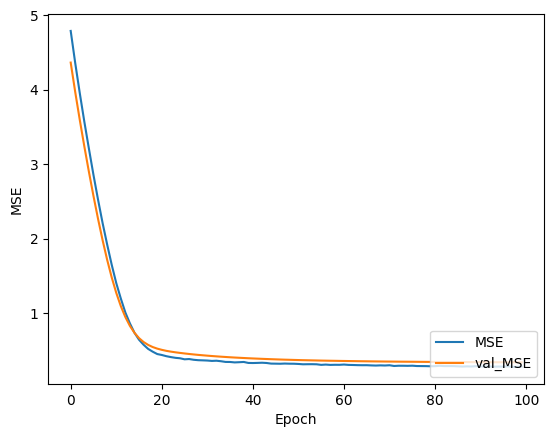

In [37]:
# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

# Train the model.
history = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

###3.1.3 Early Stopping

Early stopping simply monitors the validation data, and if it identifies that the validation accuracy/error is deteriorating then it will stop training the model further. However, you do want to leave some leeway as fitting Neural Networks can be a bit stochastic, so you don't want to immediately stop the first time the validation loss increases. This tolerance is called the `patience` and is a hyperparamter that says how many iterations it will tolerate with a loss above the best observed value. You may need to experiment with so that you can hit the sweet spot of not overfitting but also not ending your training prematurely.

This can simply be done by making a callback instance and defining this when fitting the model, there is an example on a simple model below (callback information in the second cell)

In [38]:
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
X_raw=X_raw[0:500,0:2]
Y = Y_pd.to_numpy()
Y=Y[0:500]

X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=128*4, activation=relu)
second_layer = Dense(units=128*4, activation=relu)
third_layer = Dense(units=128*4, activation=relu)
forth_layer = Dense(units=128*4, activation=relu)
fifth_layer = Dense(units=128*4, activation=relu)
out_layer = Dense(units=1, activation=linear)

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = third_layer(output)
output = forth_layer(output)
output = fifth_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Early_Stop')
model.summary()

Model: "Early_Stop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_38 (Dense)            (None, 512)               1536      
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 dense_40 (Dense)            (None, 512)               262656    
                                                                 
 dense_41 (Dense)            (None, 512)               262656    
                                                                 
 dense_42 (Dense)            (None, 512)               262656    
                                                                 
 dense_43 (Dense)            (None, 1)                 5

Epoch 1/100
1/1 [==============================] - 1s 963ms/step - loss: 4.5602 - val_loss: 1.8945
Epoch 2/100
1/1 [==============================] - 0s 64ms/step - loss: 1.8369 - val_loss: 0.6733
Epoch 3/100
1/1 [==============================] - 0s 65ms/step - loss: 0.6734 - val_loss: 0.5520
Epoch 4/100
1/1 [==============================] - 0s 65ms/step - loss: 0.5596 - val_loss: 0.4853
Epoch 5/100
1/1 [==============================] - 0s 65ms/step - loss: 0.4882 - val_loss: 0.4384
Epoch 6/100
1/1 [==============================] - 0s 80ms/step - loss: 0.4586 - val_loss: 0.4495
Epoch 7/100
1/1 [==============================] - 0s 102ms/step - loss: 0.4577 - val_loss: 0.4325
Epoch 8/100
1/1 [==============================] - 0s 83ms/step - loss: 0.4732 - val_loss: 0.5494
Epoch 9/100
1/1 [==============================] - 0s 80ms/step - loss: 0.5511 - val_loss: 0.5200
Epoch 10/100
1/1 [==============================] - 0s 70ms/step - loss: 0.5826 - val_loss: 0.8746


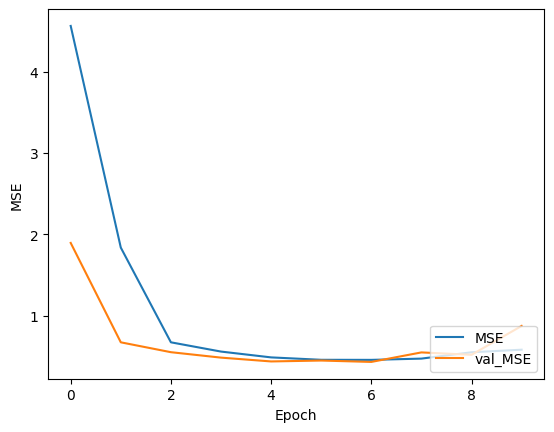

In [39]:
# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.1)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

###################################################################################
# Early Stopping
# Choose what metric to monitor (validation accuracy a good metric for overfitting in regression)
# Patience is how many iterations with a loss above the lowest observed value will be tolerated
callback = EarlyStopping(monitor='val_loss', patience=3)
####################################################################################

# Train the model.
history = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_valid, Y_valid), verbose=1, callbacks=[callback])

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')

## 3.2 Saving your model

Sometimes it can take a long time to train a model that uses big data or is very complex, so obviously you don't want to lose this progress, but one issue with using Colab is that it clears out your runtime every time you stop using it.

For that reason, you may want to save the trained weights of your model so you can come back to it later and improve it, or use it for making predictions on other data.

If you are interested in learnign more about this, I would direct you to [TensorFLow's tutorial on the topic.](https://www.tensorflow.org/tutorials/keras/save_and_load)

I won't go into this in any further detail here, as it should not be an issue for your coursework or any of the tutorials. But I thought it would be useful to let you know this is an option in case it is relevant to you later in your MSC project or in your work.

## 3.3 Exercise 4


Try using this rough framework to experiment with a few different parameters


1.   Try training the models for more epochs when calculating the regularisation weight.
2.   Try finding the best learning weight for your model
3.   Try testing different number of hidden units.
4.   Change the number of layers and try testing all of the above again, do you get different results?



In [40]:
##############################################################
# Your code here
##############################################################

# First we can define some functions to create our model then compile and train it
# This should make our lives a bit easier and the code clearer when it comes to finding the paramaters
def create_model(reg_str=0.01,n_hidden=50):
    kernel_regularizer = L2(l2=reg_str)
    dense_layer_1 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    dense_layer_2 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    out_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)
    input=Input(shape=X_train.shape[1:]) 
    # Note, we can stack our layers in a single line like this to save space, but this approach does make it harder adding and removing layers.
    output = out_layer(dense_layer_2(dense_layer_1(input)))    
    model = Model(inputs=[input], outputs=[output], name='Exercise_4')
    return model

def model_compile_and_training(X_train, Y_train, X_valid, Y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100):
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid, Y_valid), verbose=0) # Verbose=0 suppresses the output
    return model, history

4/4 [==============================] - 0s 6ms/step
The best number of units: 100


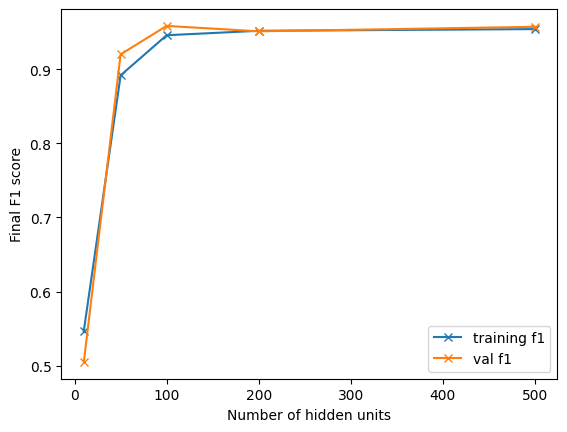

In [41]:
# Load the breast cancer dataset
X_pd, y_pd = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Convert the target column vector `Y_pd` into 2-dimensional array (a `pd.DataFrame` instance)
Y_pd = y_pd.to_frame()

# prepare NumPy ndarrays
X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

hidden_units = [10, 50, 100, 200, 500]
train_array = np.full([len(Cs)], np.nan)
valid_array = np.full([len(Cs)], np.nan)
f1_train_array = np.full([len(Cs)], np.nan)
f1_valid_array = np.full([len(Cs)], np.nan)

for HU_index, nh in enumerate(hidden_units):
  # Run our two functions to create and compile the model
  model = create_model(reg_str=0.01,n_hidden=nh)
  model_compile_and_training(X_train, Y_train, X_valid, Y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100)

  Y_pred_train = model.predict(X_train)
  Y_pred_train = (Y_pred_train > 0.5).astype(int)

  train_array[HU_index] = accuracy_score(Y_train, Y_pred_train)
  f1_train_array[HU_index] = f1_score(Y_train, Y_pred_train, pos_label=1)

  Y_pred_valid = model.predict(X_valid)
  Y_pred_valid = (Y_pred_valid > 0.5).astype(int)

  valid_array[HU_index] = accuracy_score(Y_valid, Y_pred_valid)
  f1_valid_array[HU_index] = f1_score(Y_valid, Y_pred_valid, pos_label=1)


# Select our best performing number of units (biggest f1)
best_hidden_index = np.argmax(f1_valid_array)
best_units = hidden_units[best_hidden_index]
print('The best number of units:', best_units)

# plot the results
plt.figure()
plt.plot(hidden_units, f1_train_array, '-x', label='training f1')
plt.plot(hidden_units, f1_valid_array, '-x', label= 'val f1')
plt.xlabel('Number of hidden units')
plt.ylabel('Final F1 score')
plt.legend()

##3.4 Exercise 5

Use this parametric testing approach used above to try exploring the hyperparameters for your regression problem in **Exercise 1** to obtain the best model you can. I don't have a particular 'perfect' answer in mind here, what I want you to do is experiment with many of the aspects of a neural network discussed at the start of this section to see what the best model you can obtain is. This may involve multiple passes where you change the number of layers in the model (or their activation function, or some other fundamental change) and then you can work on optimising the hyperparameters.

**Warning**: It may take some time for the paramatric test to complete if you are running a model with many layers/units for potentially hundereds of epochs. It's imposible to train every permutation of model ever, all we can hope to do is advance things logically and systematically (e.g. pick an initial model structure, try tuning the hyperparameters on this model, once you have these hyperparameters you can experiment with changing the model layout. Then you may want to go back again and see if tuning the hyperparameters for this new model improves things). You also may want to try fitting a model on a subest of the data for speed, then try doing the final tunings on the full dataset once you have a model setup you are fairly happy with.

In [42]:
##############################################################
# Your code here
##############################################################
# First we can define some functions to create our model then compile and train it
# This should make our lives a bit easier and the code clearer when it comes to finding the paramaters
def create_model(reg_str=0.01,n_hidden=50):
    kernel_regularizer = L2(l2=reg_str)
    dense_layer_1 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    dense_layer_2 = Dense(units=n_hidden, activation=relu, kernel_regularizer=kernel_regularizer)
    out_layer = Dense(units=1, activation=linear, kernel_regularizer=kernel_regularizer)
    input=Input(shape=X_train.shape[1:]) 
    # Note, we can stack our layers in a single line like this to save space, but this approach does make it harder adding and removing layers.
    output = out_layer(dense_layer_2(dense_layer_1(input)))    
    model = Model(inputs=[input], outputs=[output], name='Exercise_5')
    return model

def model_compile_and_training(X_train, Y_train, X_valid, Y_valid, learning_rate= 0.01, n_epochs= 10, batch_size=100):
    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=MeanSquaredError())
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid, Y_valid), verbose=0) # Verbose=0 suppresses the output
    return model, history

129/129 [==============================] - 0s 2ms/step - loss: nan
The best number of units: 100


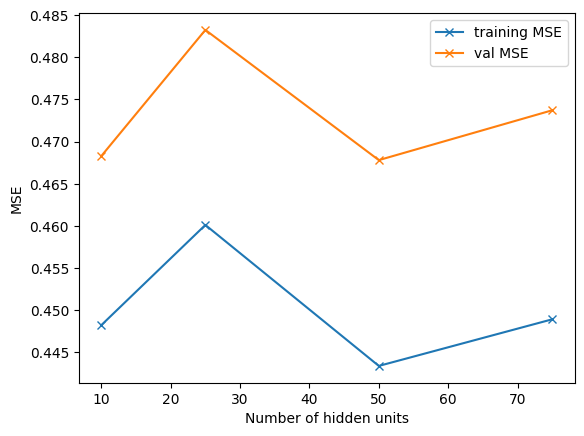

129/129 [==============================] - 0s 2ms/step - loss: nan
The mean squared error on the test data: nan
129/129 [==============================] - 0s 1ms/step


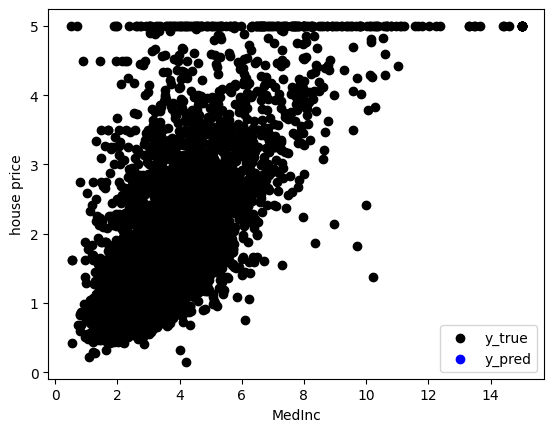

ValueError: Input contains NaN.

In [43]:
# This is just an example of how I would automate choosing the number of layers for the california housing data.
# I would expect you to do a lot more experimentation to ultimately find a model much better than this one!

X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Y_pd = y_pd.to_frame()

Y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()

# Split the data into training/test data
X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

hidden_units = [10, 25, 50, 75, 100]
train_array = np.full([len(Cs)], np.nan)
valid_array = np.full([len(Cs)], np.nan)

for HU_index, nh in enumerate(hidden_units):
  # Run our two functions to create and compile the model
  model = create_model(reg_str=0.01,n_hidden=nh)
  model_compile_and_training(X_train, Y_train, X_valid, Y_valid, learning_rate= 0.05, n_epochs= 50, batch_size=100)

  train_array[HU_index] = model.evaluate(X_train, Y_train)
  valid_array[HU_index] = model.evaluate(X_valid, Y_valid)


# Select our best performing number of units (smallest MSE)
best_hidden_index = np.argmin(valid_array)
best_units = hidden_units[best_hidden_index]
print('The best number of units:', best_units)

# plot the results
plt.figure()
plt.plot(hidden_units, train_array, '-x', label='training MSE')
plt.plot(hidden_units, valid_array, '-x', label= 'val MSE')
plt.xlabel('Number of hidden units')
plt.ylabel('MSE')
plt.legend()
plt.show()

mse_on_test = model.evaluate(X_test, Y_test)
print('The mean squared error on the test data:', mse_on_test)

Y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], Y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], Y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(Y_test, Y_test_pred)))

#Appendix 1: Sequential Models (Bonus Exercise)

In this tutorial we have been using the *functional* (`Model`) api for creating our neural networks ([see here for documentation](https://www.tensorflow.org/guide/keras/functional/)), but this isn't the only way we can create them.

Another very common way of constructing Neural Networks is to use the `Sequential` model api ([see here for documentation](https://www.tensorflow.org/guide/keras/sequential_model)). Less common (in my experience), but you may also encounter how to make models using *subclassing*, which I won't cover here ([see here for documentation](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)).

I have chosen to use the `Model` api as I feel it offers you the best compromise between useability and being able to quite easily incorperate some more advanced functionality (such as transfer learning and multiple outputs).

However, if you just want to create a linear Neural Network from scratch, the `Sequential` api is perfectly accepable and quite intuitive to use, so feel free to use either method for your coursework.

Below I have just implemented the first basifc Neural Network we used at the start of the tutorial.

**Bonus Exercise** This model is quite bad (certainly needs more training), see if you can get to grips with the sequential API and remake whatever your solution was for *Exercise 1*. You could also try remaking one of your classification models using this approach.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 5)                 45        
                                                                 
 dense_109 (Dense)           (None, 5)                 30        
                                                                 
 dense_110 (Dense)           (None, 1)                 6         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1s 22ms/step - loss: 2.5586 - val_loss: 1.8747
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 1.6021 - val_loss: 1.4623
Epoch 3/100
13/13 [==============================] - 0s 12ms/step - loss: 1.3771 - val_loss: 1.3596
Epoch 4/100
13/13 [====

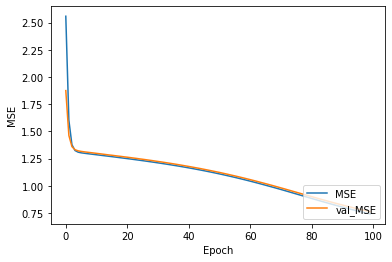

129/129 [==============================] - 0s 2ms/step - loss: 0.7556
The mean squared error on the test data: 0.7556191682815552
129/129 [==============================] - 0s 1ms/step


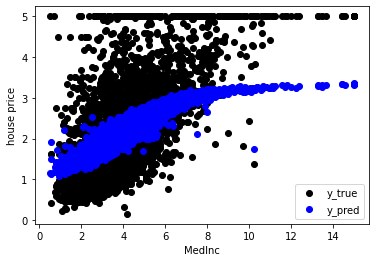

R2 score: 0.4205


In [ ]:
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Y_pd = y_pd.to_frame()

X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()


X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

##################################################
# Everything else in this should be the same as our initial example
# Here we define our model first and add dense layers one at a time
# While a bit simpler to understand, this approach is less flexible and doesn't allow us to do as much as the functional api.
model = Sequential()
# Note, we don't need to define an input layer, just specidy the input dimension for the first layer.
model.add(Dense(5, input_dim=len(X_train[1]),activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='linear'))
##################################################

# Should see that this is the same as the model we made earlier in the first example.
model.summary()

sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

history = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

mse_on_test = model.evaluate(X_test, Y_test)
print('The mean squared error on the test data:', mse_on_test)

Y_test_pred = model.predict(X_test)

# Plot our predictions
plt.scatter(X_test_raw[:,0], Y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], Y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(Y_test, Y_test_pred)))

#Appendix 2: Multiple outputs (Bonus Exercise)

I haven't mentioned this so far, and you have not been asked to do this for your coursework, but you should be aware that your models (not just Neural Networks) are capable of predicting multiple target outputs. Of course, you could just make two seperate models to do this, but combining them certainly makes the coding workflow easier to follow.

Just to show you how easy this is to do I have made a model predicting both the house value and the average rooms for the Califoria Housing dataset. The functional api actually allows for complicated branching outputs that means you could have entirely seperate layers being trained for each output and also means that (for example) a single model could perform regression and classification, among all sorts of other wierd and wonderful complicated model constructions. But this becomes quite complicated and is far beyond the scope of what you need to know for this module, so I will leave researching that to you if your are interested.

**Bonus Task** I have not optimised this model very much, so see if you can improve the performance for both targets!

Model: "Appendix_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_95 (Dense)            (None, 10)                80        
                                                                 
 dense_96 (Dense)            (None, 10)                110       
                                                                 
 dense_97 (Dense)            (None, 2)                 22        
                                                                 
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 0s 12ms/step - loss: 15.5830 - val_loss: 11.7753
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 5.3058 - val_lo

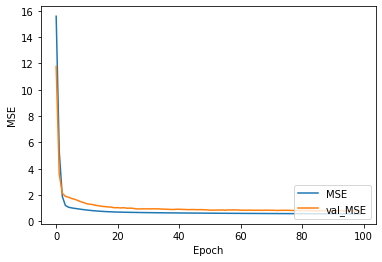

129/129 [==============================] - 0s 2ms/step - loss: 0.6162
The mean squared error on the test data: 0.6162230968475342
129/129 [==============================] - 0s 1ms/step


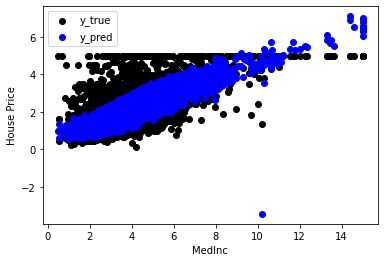

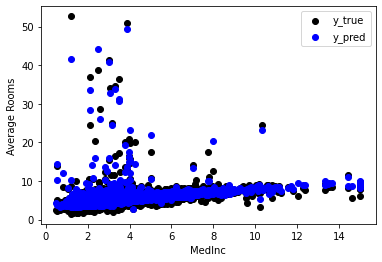

R2 score (House Price): 0.5778
R2 score (Average Rooms): 0.8673


In [ ]:
# Here I am pulling the data into a single frame, then splitting it up into out two column target matrix and our reduced feature matrix (now missing the average rooms)
# There may be a more elegant way to do this process.
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Y_pd = y_pd.to_frame()
XY_pd = pd.concat([X_pd, Y_pd], axis=1)
Y_pd=XY_pd[['MedHouseVal','AveRooms']]
X_pd=XY_pd
X_pd.drop(columns=['AveRooms','MedHouseVal'], inplace=True)
X_raw = X_pd.to_numpy()
Y = Y_pd.to_numpy()

X_nontest_raw, X_test_raw, Y_nontest, Y_test = train_test_split(X_raw, Y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, Y_train, Y_valid = train_test_split(X_nontest_raw, Y_nontest, test_size=0.25, shuffle=True, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

first_layer = Dense(units=10, activation=relu)
second_layer = Dense(units=10, activation=relu)
#############################################
# This is the key step - here we are specifying two output units rather than 1 as we have been doing elsewhere.
out_layer = Dense(units=2, activation=linear)
#############################################

input = Input(shape=X_train.shape[1:])
output = first_layer(input)
output = second_layer(output)
output = out_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output], name='Appendix_2')
model.summary()

# Compile the model by specifying the optimization algorithm and the loss function.
sgd = SGD(learning_rate=0.01)
mse = MeanSquaredError()
model.compile(optimizer=sgd, loss=mse)

# Train the model.
history = model.fit(X_train, Y_train, batch_size=1000, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

mse_on_test = model.evaluate(X_test, Y_test)
print('The mean squared error on the test data:', mse_on_test)

Y_test_pred = model.predict(X_test)

# Plot our predictions
# MedInc
plt.scatter(X_test_raw[:,0], Y_test[:,0],  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], Y_test_pred[:,0], color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('House Price')
plt.legend()
plt.show()
# AveRooms
plt.scatter(X_test_raw[:,0], Y_test[:,1],  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], Y_test_pred[:,1], color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('Average Rooms')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score (House Price): {:.4f}'.format(sklearn.metrics.r2_score(Y_test[:,0], Y_test_pred[:,0])))
print('R2 score (Average Rooms): {:.4f}'.format(sklearn.metrics.r2_score(Y_test[:,1], Y_test_pred[:,1])))